# Circle Packing using Neural Networks

In [1]:
import os

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
from tensorflow.keras import Input, layers
from tensorflow.keras.layers import Layer, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy as CCE
from tensorflow.keras.optimizers import Adam, Nadam, SGD
from tensorflow.keras.constraints import MinMaxNorm
from tensorflow.keras.activations import tanh
from tensorflow.keras import backend as K

In [4]:
from tensorflow.keras.optimizers.schedules import CosineDecay

In [5]:
from tensorflow.keras.regularizers import L1
l1 = L1(l1=0.01)

In [6]:
def one_hot(a, num_classes):
    return tf.constant(np.eye(num_classes, num_classes)[a], dtype=tf.float32)

In [7]:
def combination_relu(x):
    return (K.relu(x+2) - K.relu(x-2) - 2)/2

In [8]:
def modified_tanh(x):
    return tanh(x/2)

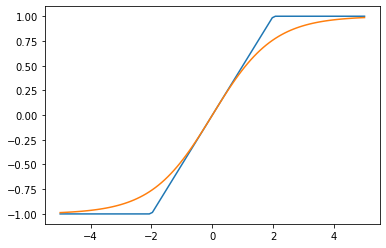

In [9]:
x = np.linspace(-5,5,100)
y = combination_relu(x)
z = modified_tanh(x)

plt.plot(x,y)
plt.plot(x,z)

## Plot Circles

In [10]:
def plot_circles(centres, epoch_num, curr_density = 0):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.scatter(0,0, color = 'red')
    ax.add_patch(plt.Circle((0,0), radius = larger_radius, fill = False, linewidth = 2.0, color = 'black'))
    ax.axis('scaled')
    for centre in centres:
        ax.add_patch(plt.Circle(centre, radius = smaller_radius, fill = False, linewidth = 1.0, color = 'blue'))
    #ax.add_patch(plt.Circle((0,0), radius = 3, fill = False, ls = '--', color = 'cyan'))
    
    if curr_density:
        fig.suptitle(f'Packing Fraction: {curr_density}', fontsize=25);
    plt.grid()
    plt.savefig(f"circles_epoch{epoch_num}")
    plt.show()

## Find Packing Density Monte-Carlo

In [11]:
def find_packing_density(centres, r, R):
    '''
    centres: centres of the spheres [N,2], N: Number of spheres
    r: radius of each circle
    R: radius of enclosing circle
    '''
    
    NumSamples = 10000
    SamplesInCircles = 0
    
    for _ in range(NumSamples):
        polar_r = np.sqrt(np.random.uniform(0,1))*R
        polar_theta = np.random.uniform(0,1)*2*np.pi
        
        coordinate = np.array([polar_r*np.cos(polar_theta), polar_r*np.sin(polar_theta)])
        
        distances_from_centres = np.linalg.norm(coordinate - centres, axis = 1)
        
        if np.min(distances_from_centres) <= r:
            SamplesInCircles += 1
            
    
    return SamplesInCircles/NumSamples

# Layer

In [12]:
class CircularNoiseLayer(Layer):

    def __init__(self, noise_radius):

        super(CircularNoiseLayer, self).__init__()
        self.noise_radius = noise_radius

    def call(self, inputs):

        radius = np.power(np.random.uniform(0, 1, size = [inputs.shape[0],1]), 1/3)*self.noise_radius
        angle =  np.random.uniform(0, 1, size = [inputs.shape[0],1])*2*np.pi
        noise = np.hstack((radius*np.cos(angle), radius*np.sin(angle)))
        return inputs + noise

circ_noise_rad1 = CircularNoiseLayer(1)

In [13]:
class NormalizationMaxNorm(Layer):
    
    def __init__(self, maxnorm, **kwargs): # maximum possible norm for weights
        super(NormalizationMaxNorm, self).__init__(**kwargs)
        self.maxnorm = maxnorm
            
    def build(self, input_shape):
        self.w = self.add_weight(shape = input_shape, 
                                 constraint = lambda x: tf.clip_by_norm(self.w, self.maxnorm, 1),
                                 trainable=True)
        
    def call(self, inputs):
        return tf.math.multiply(inputs, self.w)
    
NormalizationLayer = NormalizationMaxNorm(3)

In [14]:
class EncoderFinalLayer(Layer):
    
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        
    def build(self, input_shape):
        
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 #constraint = lambda x: tf.clip_by_norm(self.w, .1, 1),
                                 trainable=True)
        
        
        self.b = self.add_weight(shape=(input_shape[0], self.units),
                                 #constraint = lambda x: tf.clip_by_norm(self.b, .01, 1),
                                 trainable=True)
        
    def call(self, inputs):
        return tanh(tf.matmul(inputs, self.w) + self.b)
    
FinalLayerEncoder = EncoderFinalLayer(2)

# Model

In [15]:
class Autoencoder(Model):
    
    def __init__(self, main_dim, latent_dim, R, r, **kwargs):
        super(Autoencoder, self).__init__(**kwargs)
        self.latent_dim = latent_dim
        self.main_dim = main_dim
        self.ratio = R
        self.R = 1
        self.r = r/R
        
        self.normalize = NormalizationMaxNorm(self.R-self.r) 
        
        self.noise = CircularNoiseLayer(self.r)
        
        self.encoderOutput = EncoderFinalLayer(self.latent_dim)
        
        self.encoder = tf.keras.Sequential([
            Input(shape=(self.main_dim)),
            Dense(self.main_dim, activation= modified_tanh),
            Dense(self.main_dim, activation = modified_tanh),
        ])
        
        
        self.decoder = tf.keras.Sequential([
            Dense(self.main_dim, activation = 'relu'),
            Dense(self.main_dim, activation = 'relu'),
            Dense(self.main_dim, activation='softmax')
        ])
        
     
    def call(self, x):
        encoded = self.get_encoded(x)
        normed_encoded = self.normalize(encoded)
        noisy_encoded = self.noise(normed_encoded)
        decoded = self.decoder(noisy_encoded)
        return decoded
    
    def get_encoded(self, x):
        return self.encoderOutput(self.encoder(x))
    
    def get_latent(self, x):
        return self.encoder(x)

    def get_centres(self, x):
        return self.normalize(self.get_encoded(x))*self.ratio
    
AE = Autoencoder(main_dim=16, latent_dim=2, R=4, r=1)

## Training Loop

In [16]:
NumDimensions = 2
NumSpheres = 37
larger_radius = 6.7588
smaller_radius = 1

In [17]:
batches_per_epoch = 200
num_train = NumSpheres*batches_per_epoch
unique_classes = np.arange(0, NumSpheres)
unique_inputs = one_hot(unique_classes, NumSpheres)
all_inputs = tf.tile(unique_inputs, [batches_per_epoch, 1])

In [18]:
loss = CCE()
optim = Adam(learning_rate = 0.001)
epochs = 1000
batch_size = NumSpheres
epoch_losses = []
Inputs = tf.reshape(all_inputs ,[-1, batch_size, NumSpheres])
num_batches = Inputs.shape[0]
print(num_batches)

200


In [19]:
autoencoder = Autoencoder(main_dim=NumSpheres, latent_dim=NumDimensions, R=larger_radius, r=smaller_radius)

autoencoder(unique_inputs)

<tf.Tensor: shape=(37, 37), dtype=float32, numpy=
array([[0.02676383, 0.026876  , 0.02728559, ..., 0.0267325 , 0.02735861,
        0.02639072],
       [0.02635604, 0.0267983 , 0.02755138, ..., 0.02635991, 0.02783101,
        0.02574236],
       [0.02712389, 0.02697516, 0.02713268, ..., 0.0270646 , 0.02683577,
        0.02672056],
       ...,
       [0.02644152, 0.02850462, 0.0272332 , ..., 0.02648162, 0.02701718,
        0.02648135],
       [0.02596543, 0.02767917, 0.02740492, ..., 0.02626302, 0.02769448,
        0.02601373],
       [0.02628393, 0.02681208, 0.02758214, ..., 0.02630462, 0.02791316,
        0.02567448]], dtype=float32)>

  0%|                                                                                                          | 0/1000 [00:00<?, ?it/s]

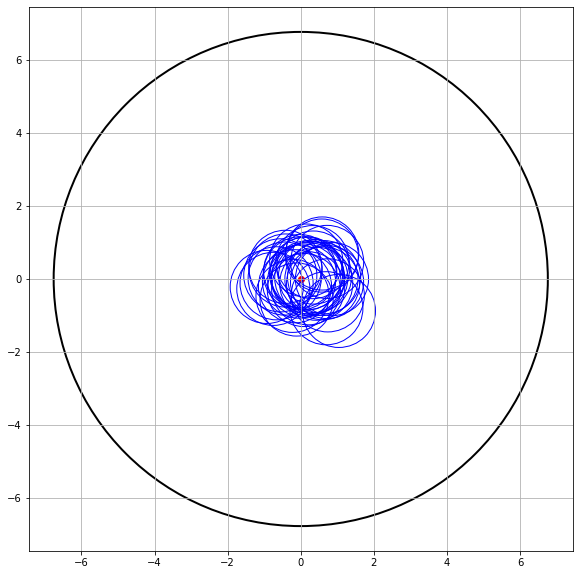

  0%|                                                                                                | 1/1000 [00:05<1:25:40,  5.15s/it]

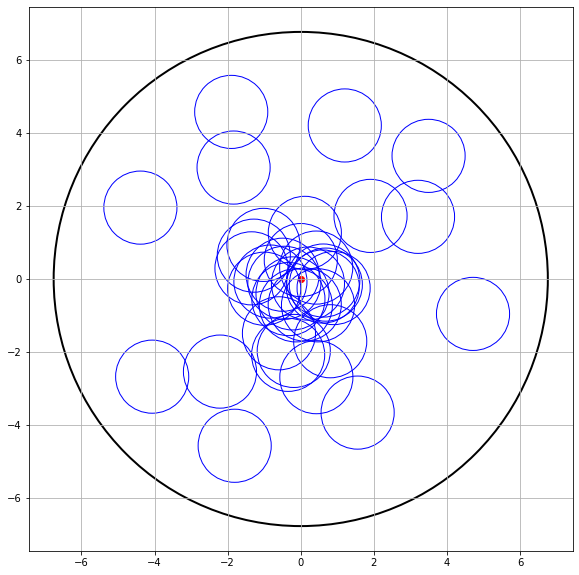

  0%|▏                                                                                               | 2/1000 [00:09<1:22:21,  4.95s/it]

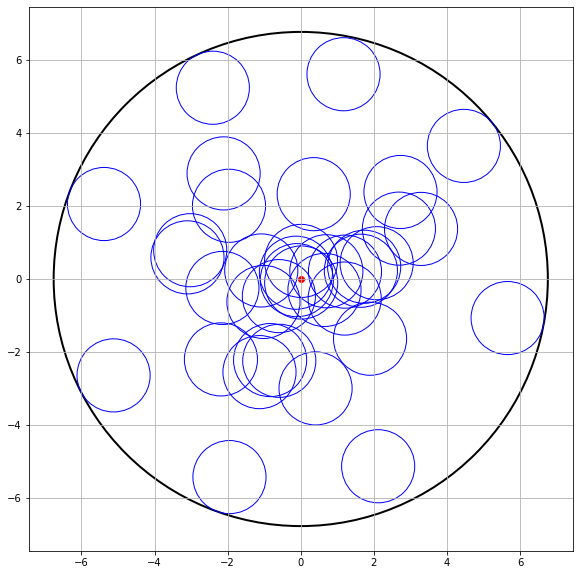

  0%|▎                                                                                               | 3/1000 [00:14<1:19:36,  4.79s/it]

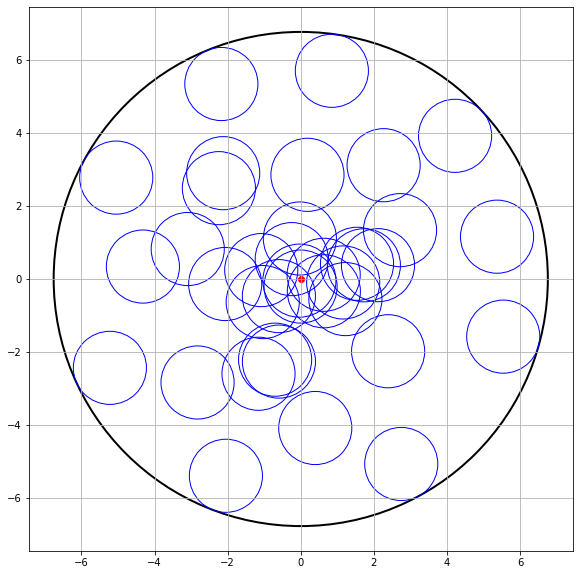

  0%|▍                                                                                               | 4/1000 [00:19<1:19:27,  4.79s/it]

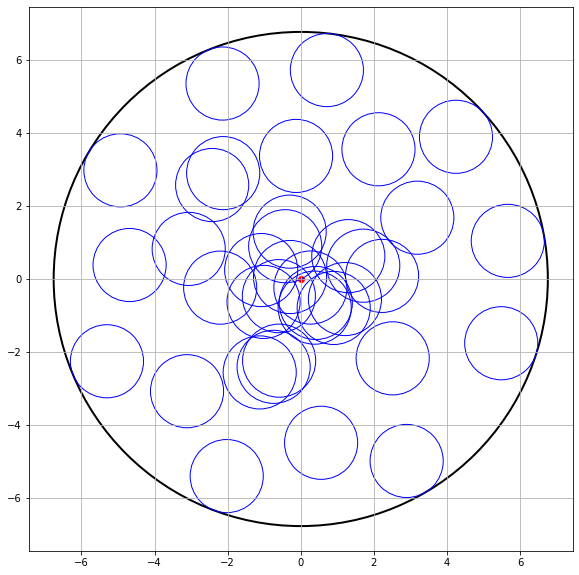

  0%|▍                                                                                               | 5/1000 [00:24<1:19:27,  4.79s/it]

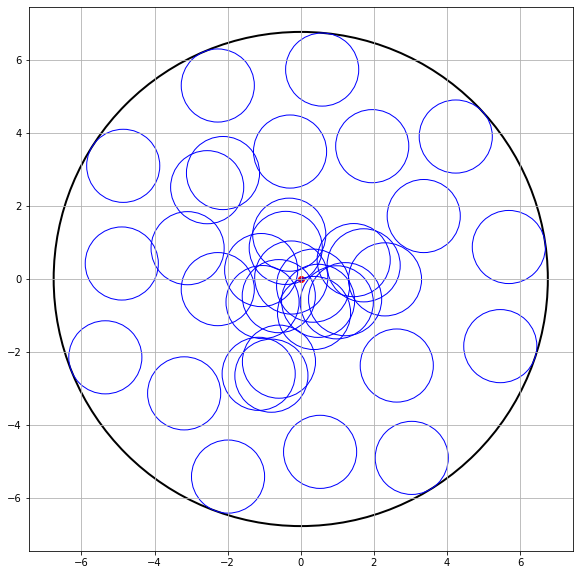

  1%|▌                                                                                               | 6/1000 [00:28<1:19:32,  4.80s/it]

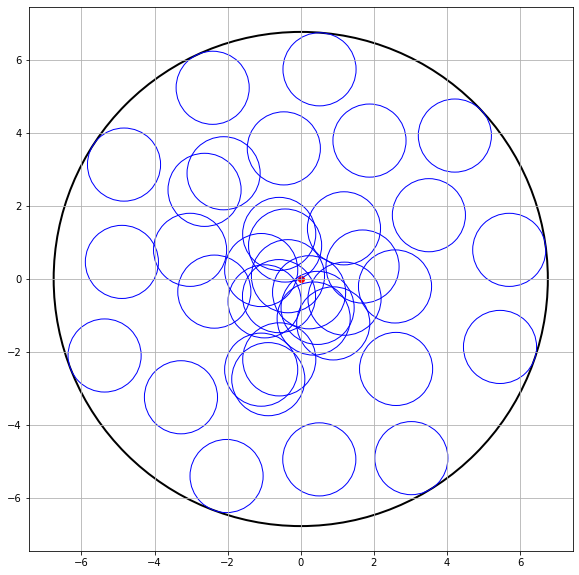

  1%|▋                                                                                               | 7/1000 [00:33<1:19:19,  4.79s/it]

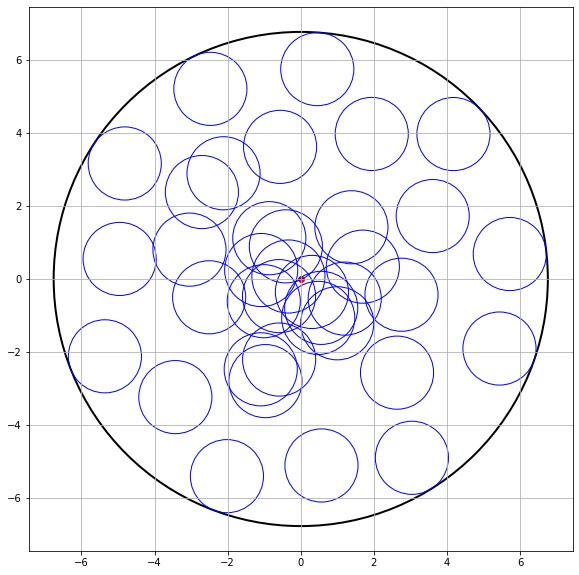

  1%|▊                                                                                               | 8/1000 [00:38<1:19:55,  4.83s/it]

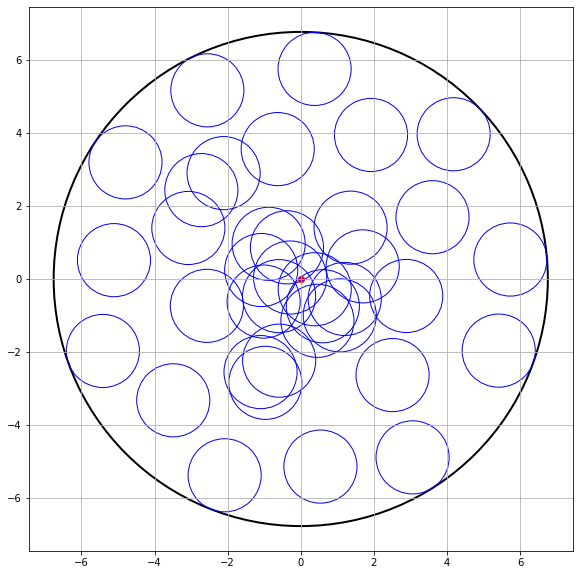

  1%|▊                                                                                               | 9/1000 [00:44<1:22:28,  4.99s/it]

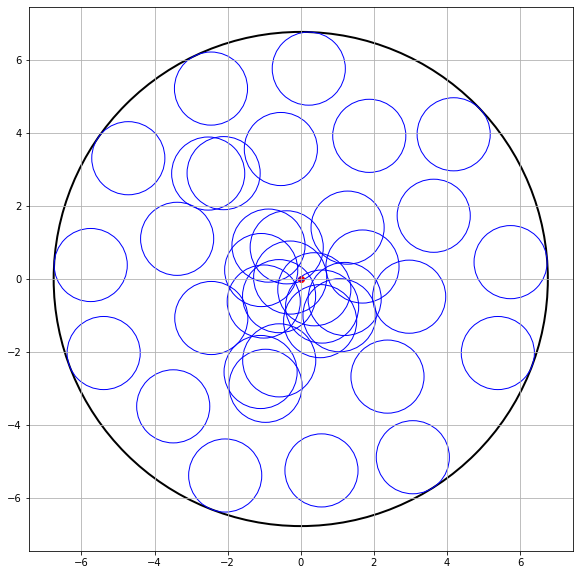

  1%|▉                                                                                              | 10/1000 [00:51<1:35:12,  5.77s/it]

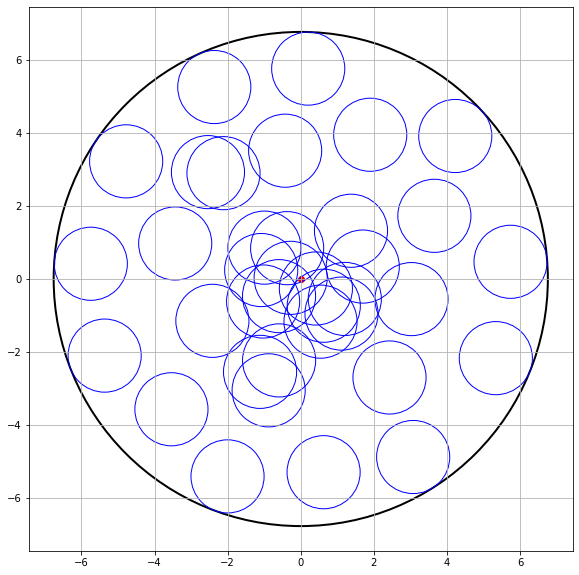

  1%|█                                                                                              | 11/1000 [01:00<1:52:40,  6.84s/it]

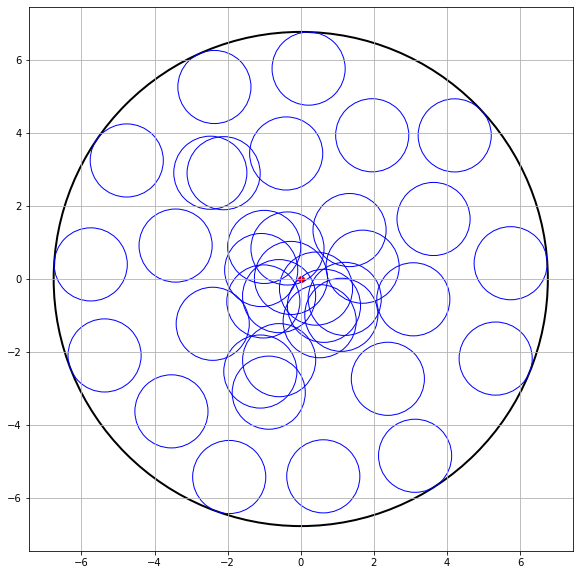

  1%|█▏                                                                                             | 12/1000 [01:09<2:04:34,  7.57s/it]

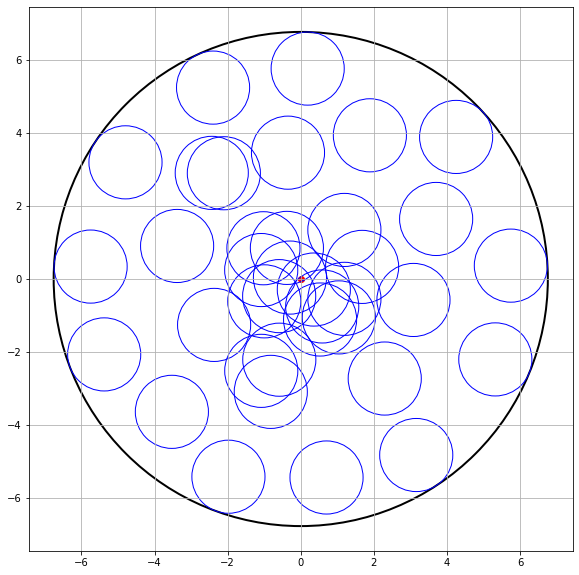

  1%|█▏                                                                                             | 13/1000 [01:17<2:05:10,  7.61s/it]

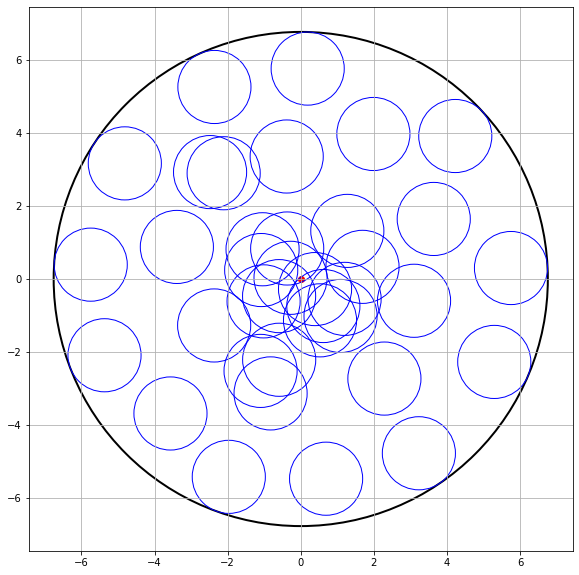

  1%|█▎                                                                                             | 14/1000 [01:24<1:59:32,  7.27s/it]

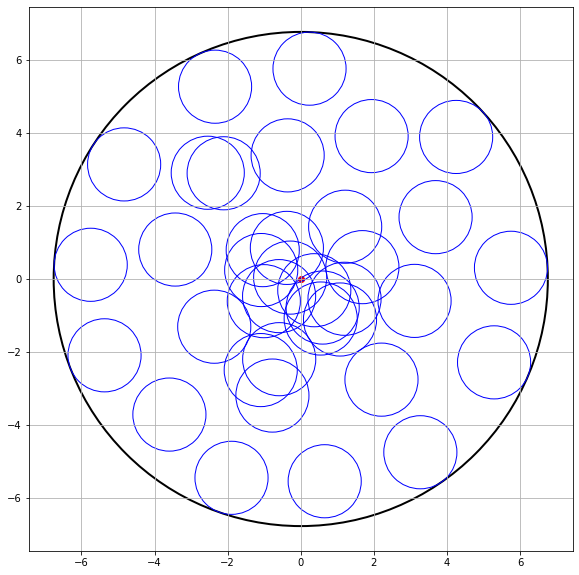

  2%|█▍                                                                                             | 15/1000 [01:29<1:51:39,  6.80s/it]

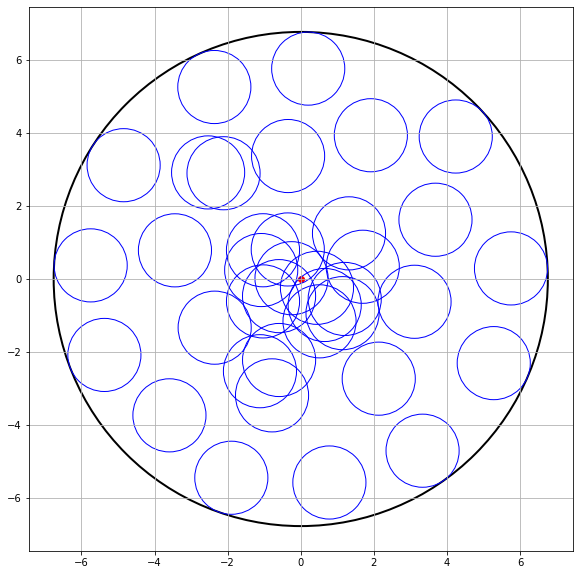

  2%|█▌                                                                                             | 16/1000 [01:35<1:43:22,  6.30s/it]

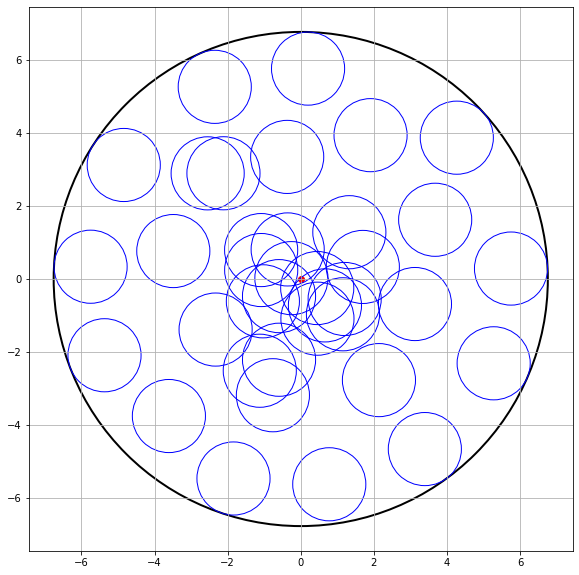

  2%|█▌                                                                                             | 17/1000 [01:40<1:40:29,  6.13s/it]

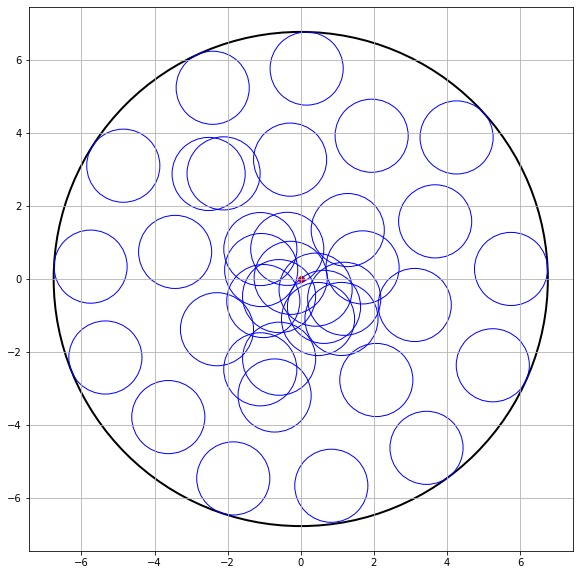

  2%|█▋                                                                                             | 18/1000 [01:46<1:38:08,  6.00s/it]

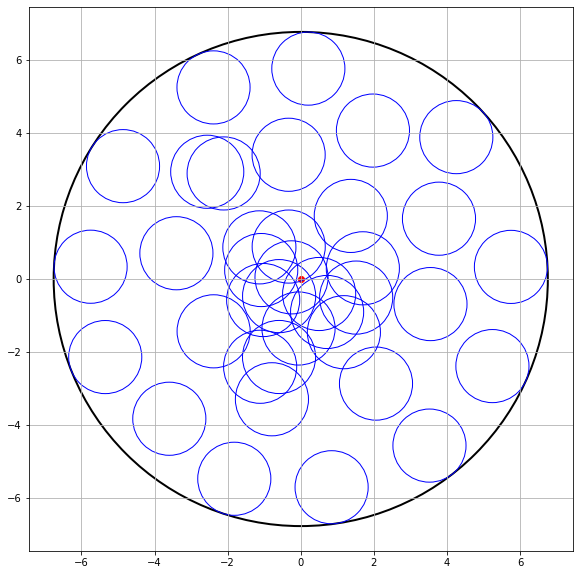

  2%|█▊                                                                                             | 19/1000 [01:52<1:39:58,  6.11s/it]

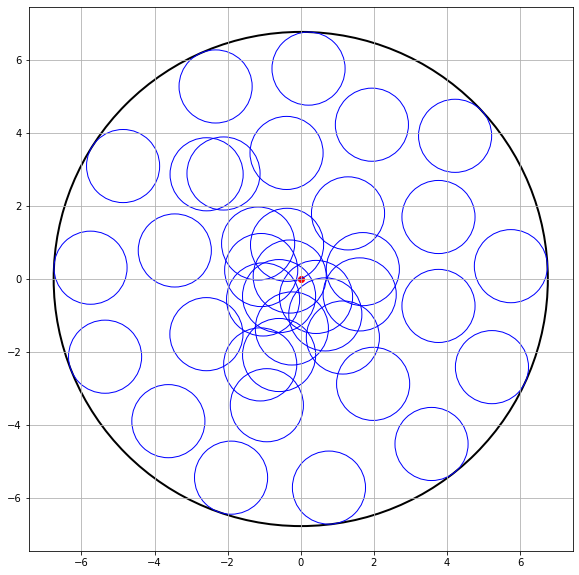

  2%|█▉                                                                                             | 20/1000 [01:58<1:39:08,  6.07s/it]

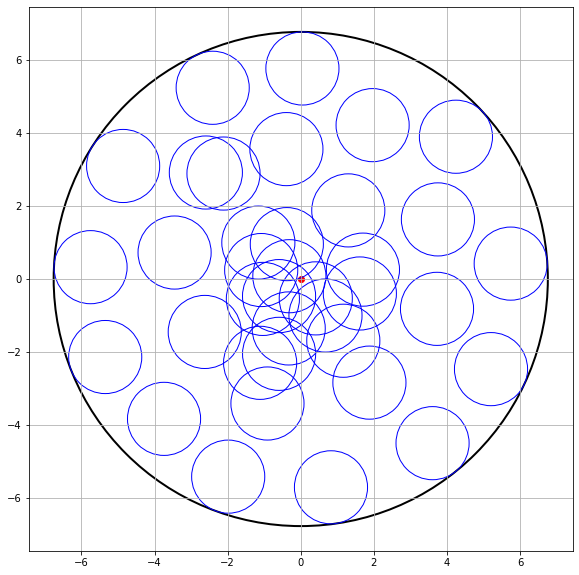

  2%|█▉                                                                                             | 21/1000 [02:05<1:41:28,  6.22s/it]

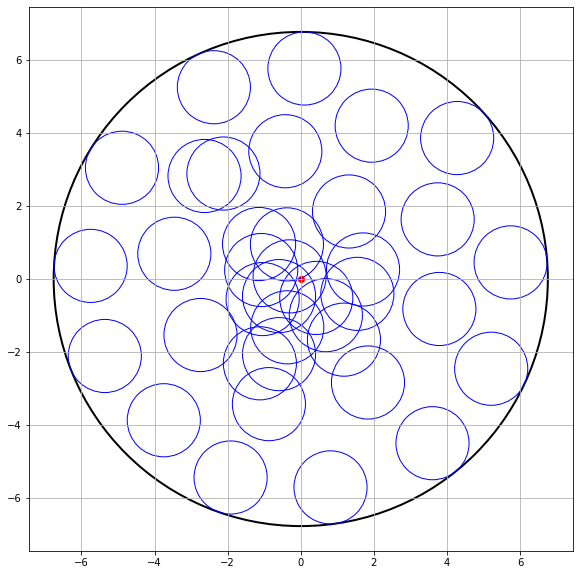

  2%|██                                                                                             | 22/1000 [02:10<1:35:41,  5.87s/it]

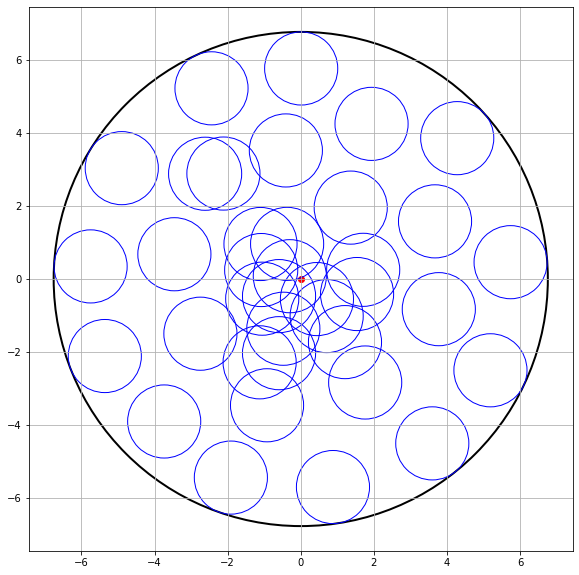

  2%|██▏                                                                                            | 23/1000 [02:15<1:31:08,  5.60s/it]

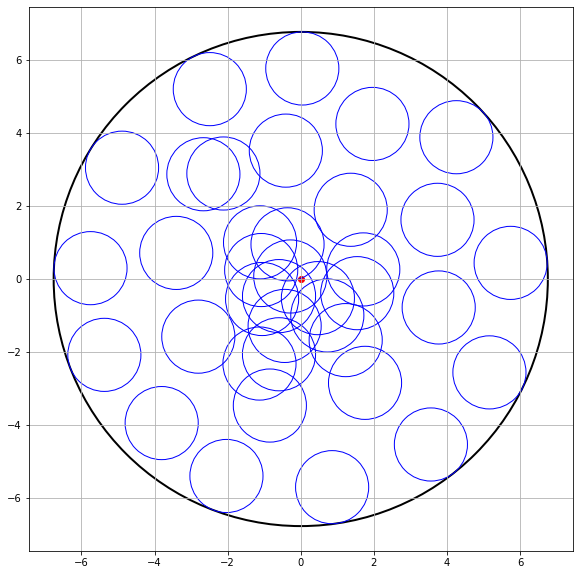

  2%|██▎                                                                                            | 24/1000 [02:20<1:30:00,  5.53s/it]

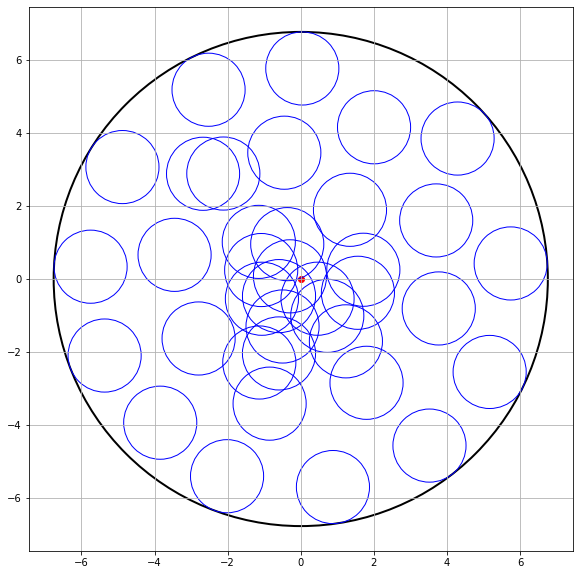

  2%|██▍                                                                                            | 25/1000 [02:25<1:27:44,  5.40s/it]

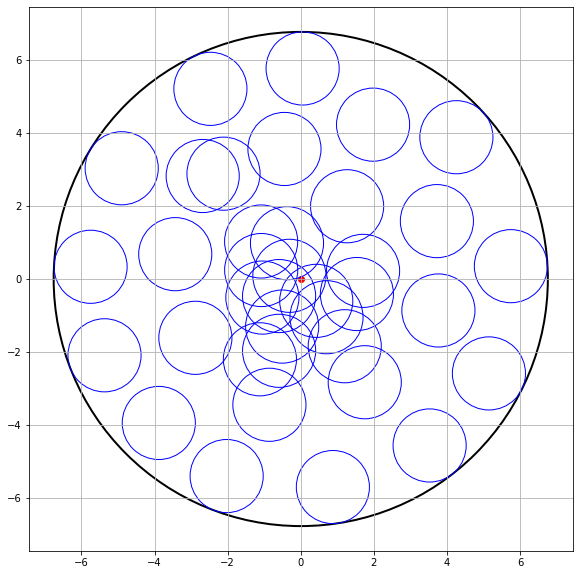

  3%|██▍                                                                                            | 26/1000 [02:30<1:25:32,  5.27s/it]

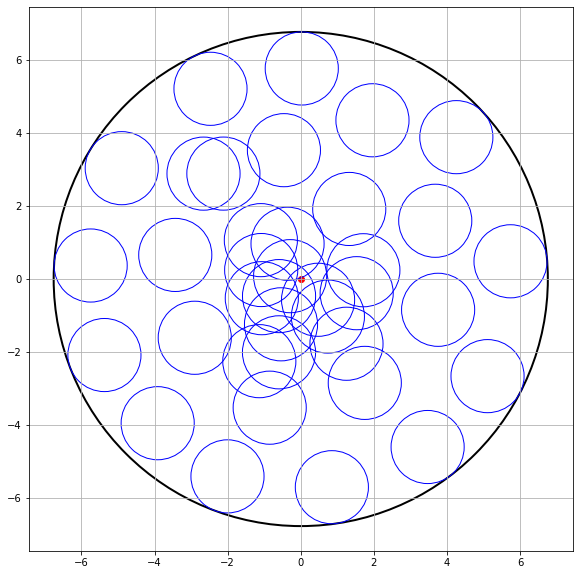

  3%|██▌                                                                                            | 27/1000 [02:35<1:23:58,  5.18s/it]

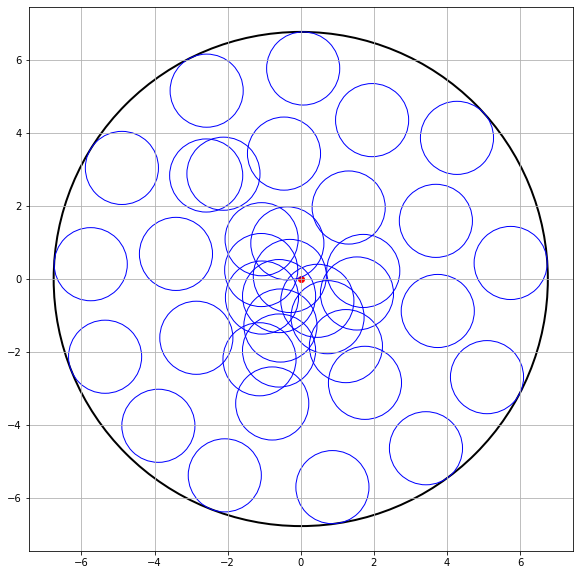

  3%|██▋                                                                                            | 28/1000 [02:40<1:22:31,  5.09s/it]

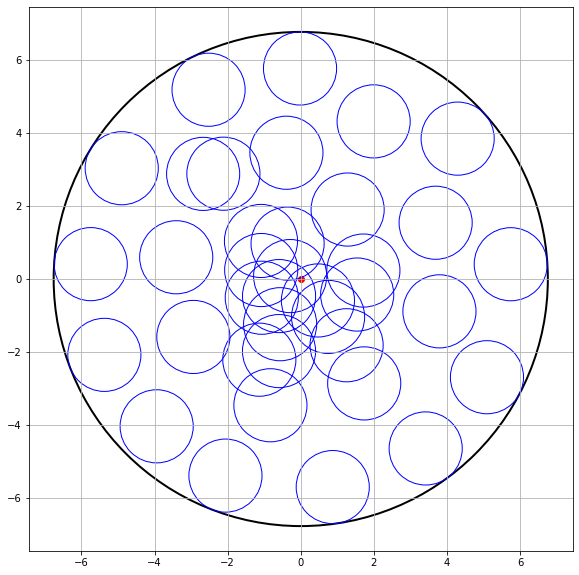

  3%|██▊                                                                                            | 29/1000 [02:45<1:21:13,  5.02s/it]

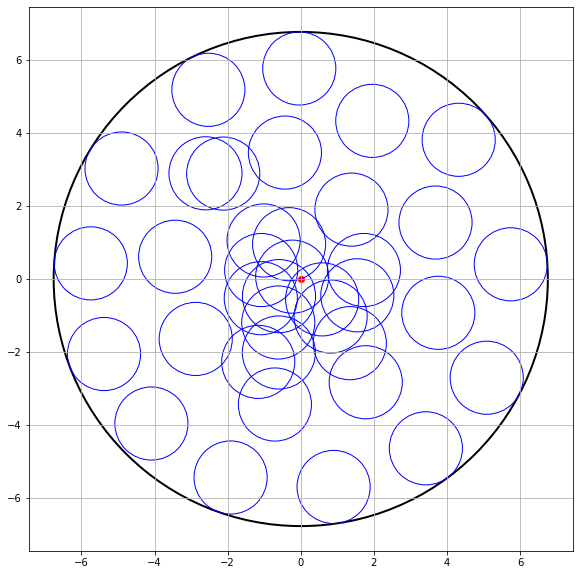

  3%|██▊                                                                                            | 30/1000 [02:50<1:20:11,  4.96s/it]

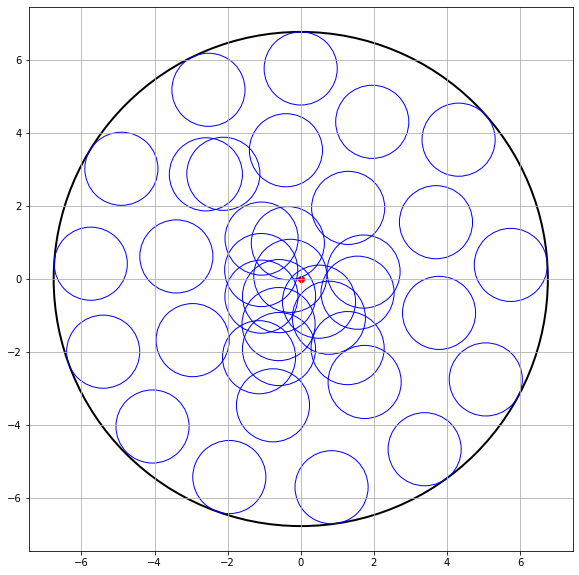

  3%|██▉                                                                                            | 31/1000 [02:55<1:19:28,  4.92s/it]

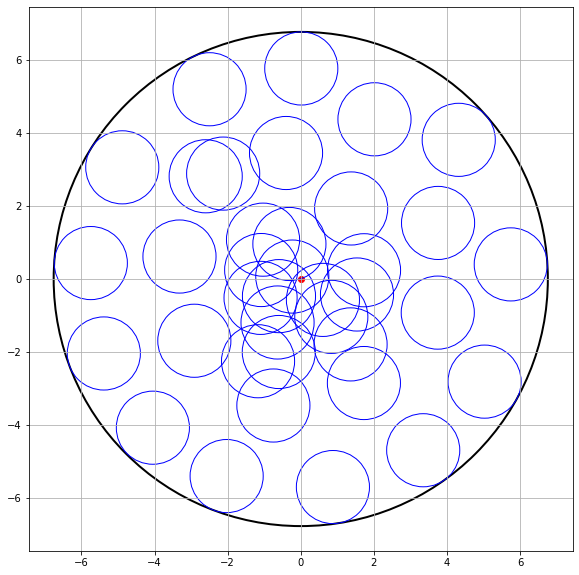

  3%|███                                                                                            | 32/1000 [03:00<1:19:15,  4.91s/it]

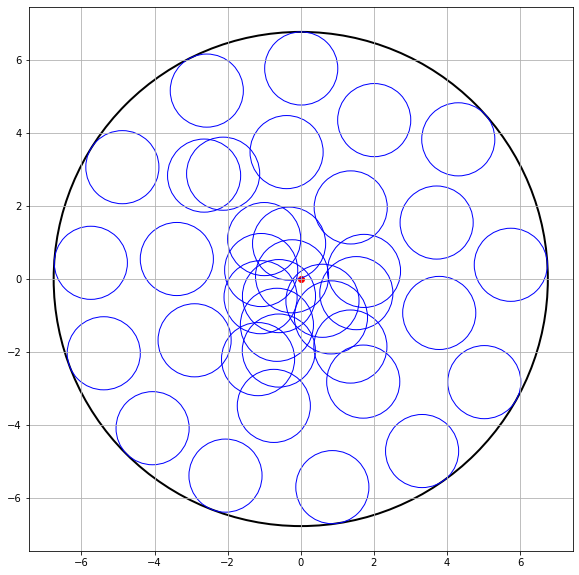

  3%|███▏                                                                                           | 33/1000 [03:04<1:18:32,  4.87s/it]

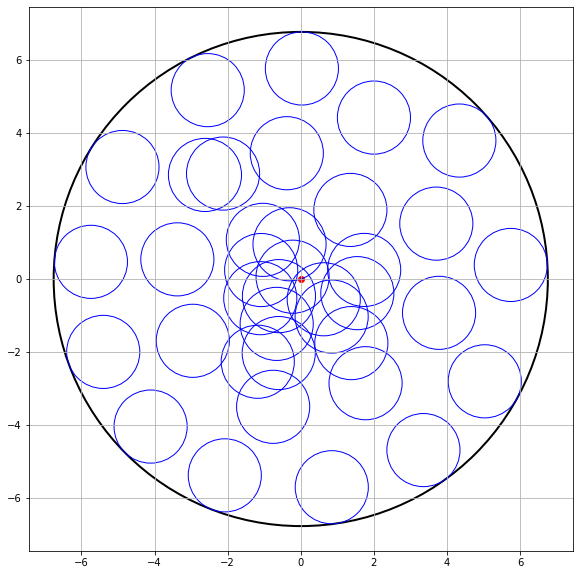

  3%|███▏                                                                                           | 34/1000 [03:09<1:17:57,  4.84s/it]

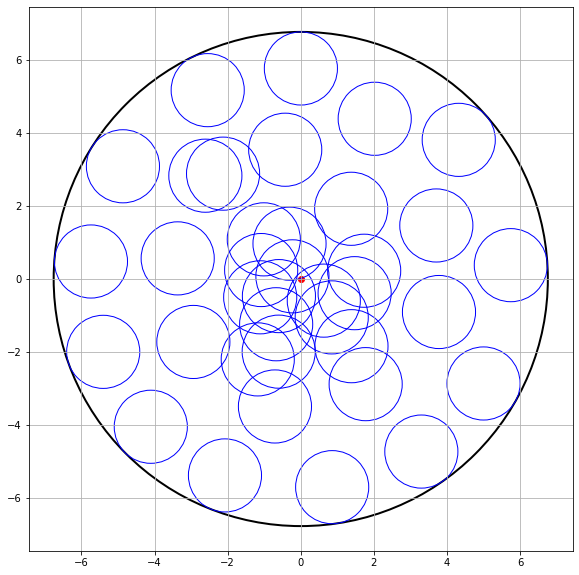

  4%|███▎                                                                                           | 35/1000 [03:14<1:17:48,  4.84s/it]

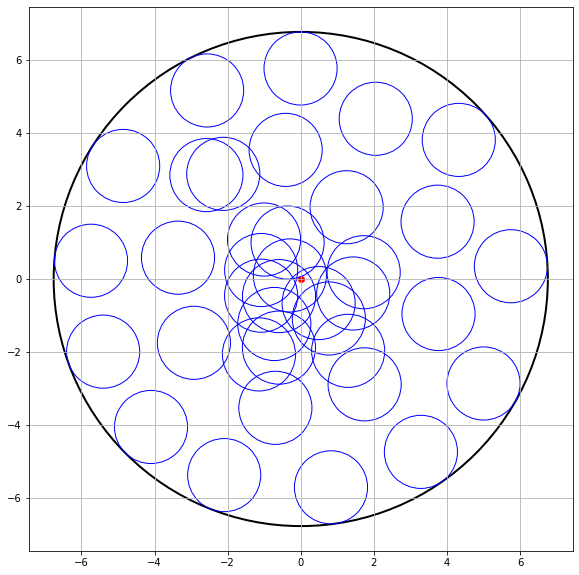

  4%|███▍                                                                                           | 36/1000 [03:19<1:18:06,  4.86s/it]

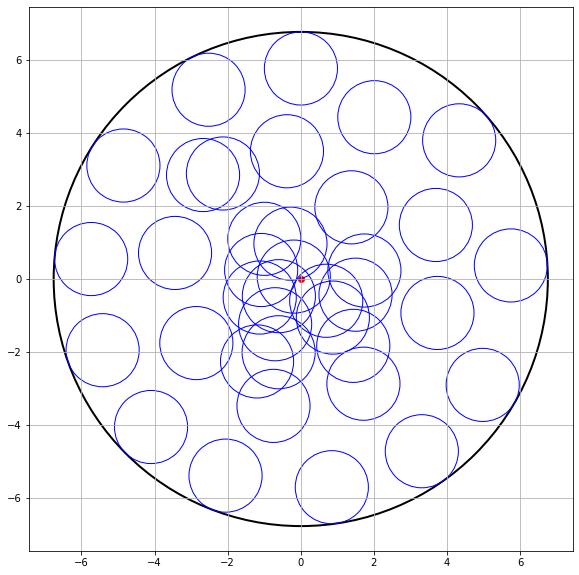

  4%|███▌                                                                                           | 37/1000 [03:24<1:17:34,  4.83s/it]

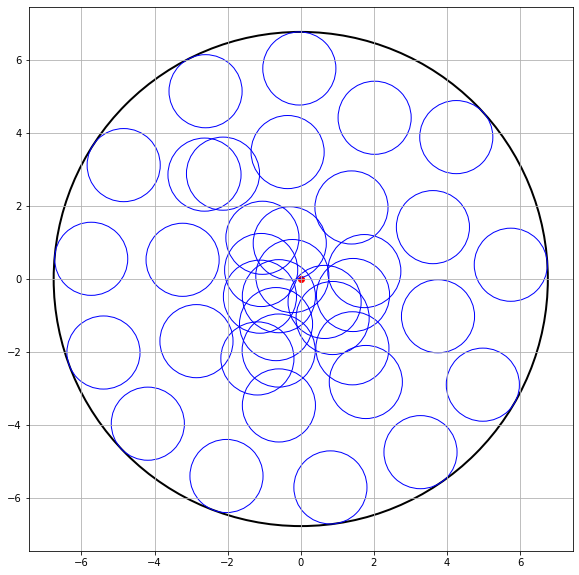

  4%|███▌                                                                                           | 38/1000 [03:29<1:18:57,  4.92s/it]

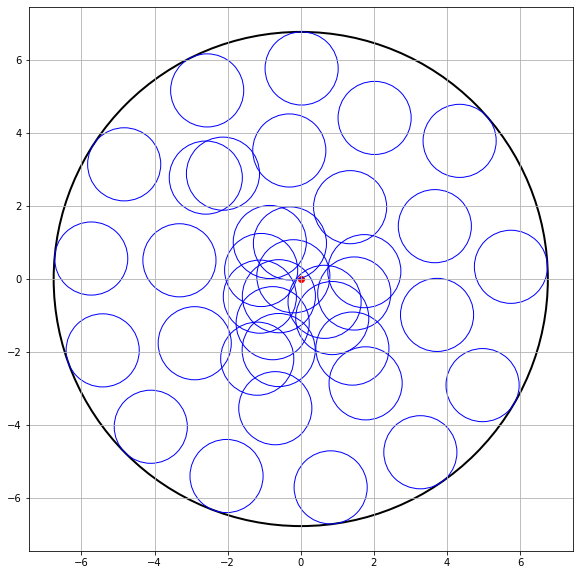

  4%|███▋                                                                                           | 39/1000 [03:34<1:18:32,  4.90s/it]

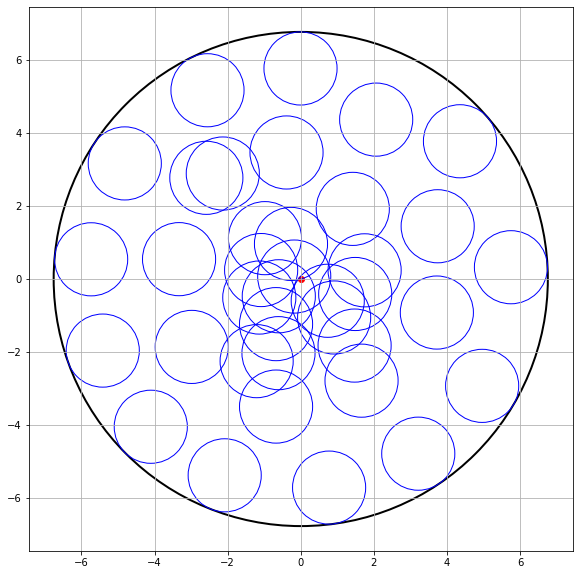

  4%|███▊                                                                                           | 40/1000 [03:40<1:27:42,  5.48s/it]

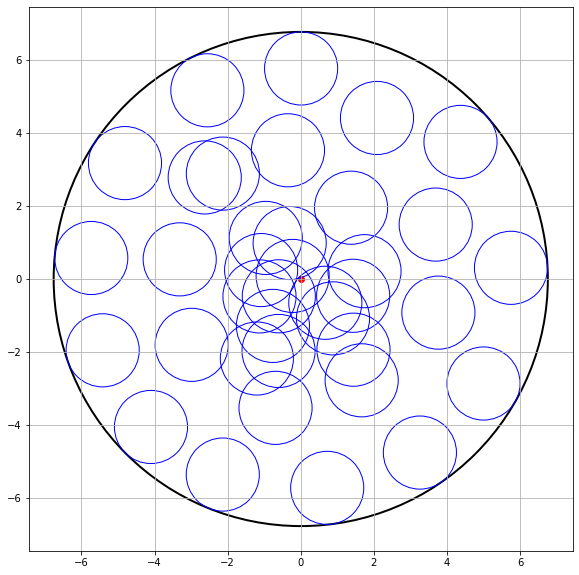

  4%|███▉                                                                                           | 41/1000 [03:46<1:28:58,  5.57s/it]

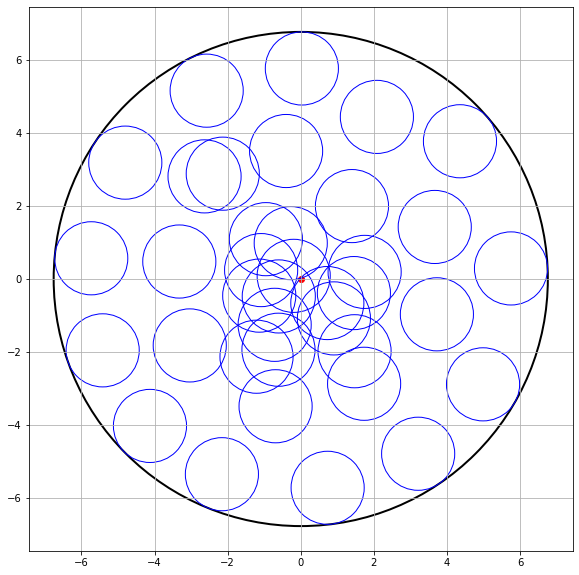

  4%|███▉                                                                                           | 42/1000 [03:51<1:26:34,  5.42s/it]

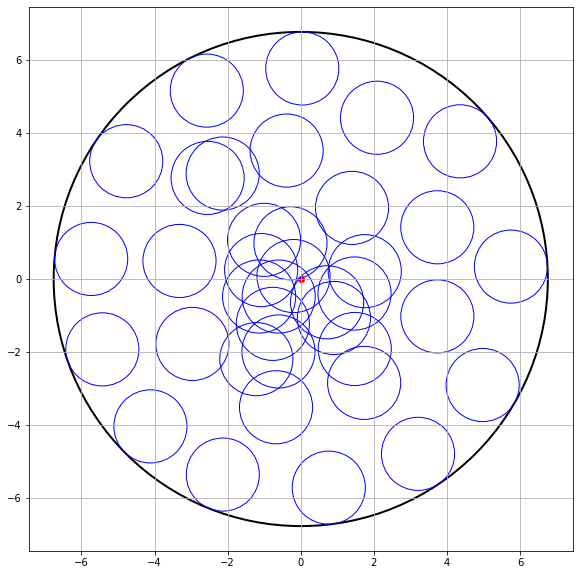

  4%|████                                                                                           | 43/1000 [03:58<1:31:38,  5.75s/it]

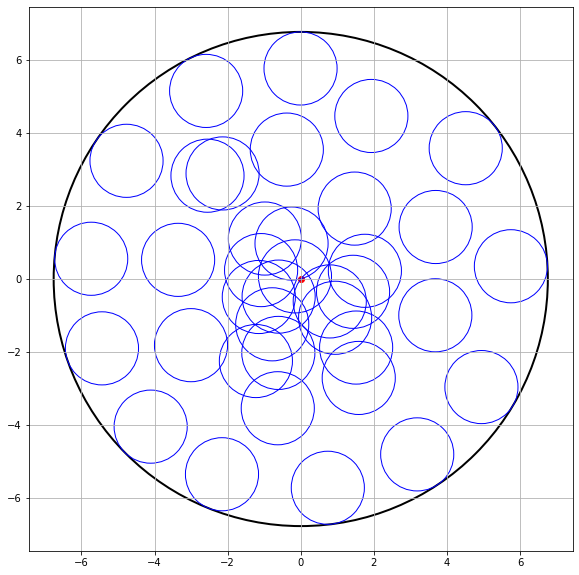

  4%|████▏                                                                                          | 44/1000 [04:05<1:39:08,  6.22s/it]

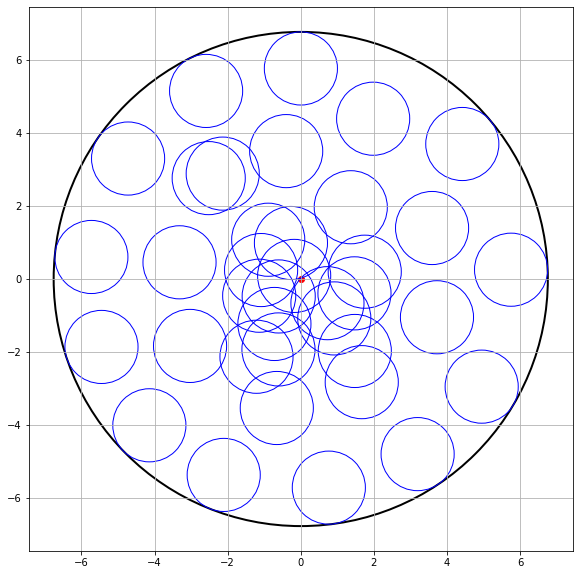

  4%|████▏                                                                                          | 44/1000 [04:10<1:30:48,  5.70s/it]


KeyboardInterrupt: 

In [20]:
for epoch in tqdm(range(epochs)):

    epoch_losses.append(loss(autoencoder(unique_inputs), unique_inputs).numpy())

    centres = autoencoder.get_centres(unique_inputs).numpy()
    plot_circles(centres, epoch+1)

    for inputs in Inputs:       
        with tf.GradientTape() as tape:
            curr_loss = loss(autoencoder(inputs), inputs)
            grads = tape.gradient(curr_loss, autoencoder.trainable_variables)
        optim.apply_gradients(zip(grads, autoencoder.trainable_variables))

## Get Centre and Make Plot

In [ ]:
centres = autoencoder.get_centres(unique_inputs).numpy()

In [ ]:
packingDensity = find_packing_density(centres, smaller_radius, larger_radius)
plot_circles(centres, epoch+1, packingDensity)

## View the learned normalization layer and its norm along axis = 1

In [ ]:
epoch_losses

In [ ]:
plt.semilogy(epoch_losses)

In [ ]:
encoder_weights = autoencoder.encoderOutput.weights
encoder_weights

In [ ]:
latent = autoencoder.get_encoded(unique_inputs)
latent

In [ ]:
wandb = [item.numpy() for item in autoencoder.encoderOutput.weights]
wandb

In [ ]:
np.linalg.norm(wandb[0], axis = 1)

In [ ]:
np.linalg.norm(wandb[1], axis = 1)

In [ ]:
weights = autoencoder.normalize.weights[0]
weights

In [ ]:
np.linalg.norm(weights, axis = 1)

# Save the model

In [ ]:
autoencoder.save_weights('saved models/37_two_out_of_place.h5')

##  Make a GIF

In [ ]:
epoch 

In [ ]:
filenames = [f"circles_epoch{i}.png" for i in range(1, epoch+2)]

In [ ]:
import imageio
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave(f"packing_{NumSpheres}_.gif", images)

# Remove the PNG files

In [ ]:
folder_path = os.getcwd()
test = os.listdir(folder_path)
test

In [ ]:
for images in test:
    if images.endswith(".png"):
        os.remove(os.path.join(folder_path, images))

# Saving Model

In [ ]:
autoencoder.save_weights('saved_models/AE_clipped_latent.h5')